<a href="https://colab.research.google.com/github/am3lia-low/battle-of-berts-FOMC/blob/main/FOMC_Step1_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOMC Hawkish-Dovish Classification — Step 1: Data Preparation & LLM Labeling
## DSA4265 Take-Home Assignment

This notebook covers:
1. Loading the FOMC Hawkish-Dovish dataset (Shah et al., 2023 — ACL)
2. Exploratory Data Analysis
3. LLM labeling of ambiguous sentences using Claude
4. Comparison of LLM labels vs human annotations
5. Train/validation/test split preparation

**Dataset:** "Trillion Dollar Words" — ~2,480 annotated FOMC sentences  
**Source:** [gtfintechlab/fomc_communication](https://huggingface.co/datasets/gtfintechlab/fomc_communication)  
**Labels:** 0 = Dovish, 1 = Hawkish, 2 = Neutral  
**Citation:** Shah, Paturi & Chava (2023). "Trillion Dollar Words: A New Financial Dataset, Task & Market Analysis." ACL 2023.

---

## 1. Setup & Installation

In [ ]:
!pip install datasets pandas matplotlib seaborn anthropic scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.9/405.9 kB 12.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
import time
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'
os.makedirs(DRIVE_PATH, exist_ok=True)
print(f"Drive path: {DRIVE_PATH}")

Mounted at /content/drive
Drive path: /content/drive/MyDrive/Colab Notebooks/


## 2. Load the FOMC Dataset

The dataset comes from the "Trillion Dollar Words" paper (Shah et al., 2023), published at ACL 2023.
It contains ~2,480 annotated sentences from three types of FOMC communications:
- **Meeting Minutes** — reports from the 8 annual FOMC meetings
- **Press Conference Transcripts** — Fed chair Q&A with reporters
- **Speeches** — public addresses by FOMC members

Each sentence is labeled as:
- **0 = Dovish** — indicates future monetary policy easing (lower rates, more money supply)
- **1 = Hawkish** — indicates future monetary policy tightening (higher rates, less money supply)
- **2 = Neutral** — factual/balanced, no clear policy direction

In [ ]:
from datasets import load_dataset

# Load from HuggingFace
dataset = load_dataset("gtfintechlab/fomc_communication")
print(f"Dataset splits: {list(dataset.keys())}")
print(f"Train size: {len(dataset['train'])}")
print(f"Test size: {len(dataset['test'])}")

# Convert to DataFrames
df_train_raw = dataset['train'].to_pandas()
df_test_raw = dataset['test'].to_pandas()

# Combine for EDA (we'll re-split later with a validation set)
df_all = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

# Label mapping
LABEL_MAP = {0: 'Dovish', 1: 'Hawkish', 2: 'Neutral'}
LABEL_MAP_REV = {v: k for k, v in LABEL_MAP.items()}
df_all['label_name'] = df_all['label'].map(LABEL_MAP)

print(f"\nTotal sentences: {len(df_all)}")
print(f"\nSample data:")
df_all[['sentence', 'label', 'label_name', 'year']].head(10)

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1984 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/496 [00:00<?, ? examples/s]

Dataset splits: ['train', 'test']
Train size: 1984
Test size: 496

Total sentences: 2480

Sample data:


,sentence,label,label_name,year
0,Broad equity price indexes fell sharply over t...,2,Neutral,2011
1,"For example, although a number of features of ...",2,Neutral,2004
2,"On balance, most participants still expected i...",2,Neutral,2005
3,Low readings on overall and core consumer pric...,0,Dovish,2008
4,But I want to emphasize that we do have a comm...,0,Dovish,2011
5,"With inflation low and resource use slack, the...",2,Neutral,1999
6,The Outlook for Economic ActivityThe midpoint ...,2,Neutral,2020
7,"Nonetheless, participants viewed the housing s...",0,Dovish,2019
8,"And then, what the statement emphasizes, and t...",0,Dovish,2017
9,Some of the increase in sentiment and changes ...,0,Dovish,2017


## 3. Exploratory Data Analysis

Key questions:
1. How balanced are the three classes?
2. How long are the sentences?
3. How are sentences distributed across years?
4. Are there differences in sentence length by class?

CLASS DISTRIBUTION
  Dovish       650  (26.2%)
  Hawkish      606  (24.4%)
  Neutral     1224  (49.4%)


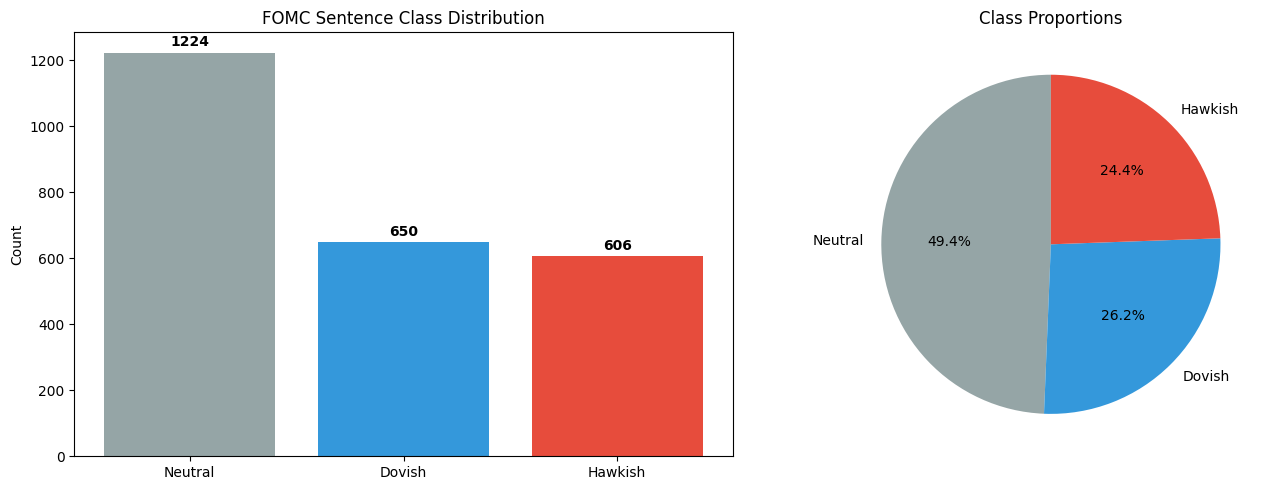

In [ ]:
# 3.1 Class distribution
print("CLASS DISTRIBUTION")
print("=" * 50)
class_counts = df_all['label_name'].value_counts()
class_pcts = df_all['label_name'].value_counts(normalize=True) * 100
for label in ['Dovish', 'Hawkish', 'Neutral']:
    print(f"  {label:<10} {class_counts[label]:>5}  ({class_pcts[label]:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = {'Dovish': '#3498db', 'Hawkish': '#e74c3c', 'Neutral': '#95a5a6'}
bars = axes[0].bar(class_counts.index, class_counts.values,
                   color=[colors[x] for x in class_counts.index])
axes[0].set_title('FOMC Sentence Class Distribution')
axes[0].set_ylabel('Count')
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 10,
                 str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=[colors[x] for x in class_counts.index], startangle=90)
axes[1].set_title('Class Proportions')

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

SENTENCE LENGTH STATISTICS
  Mean words:   30.2
  Median words: 28.0
  Min words:    2
  Max words:    181
  Std words:    15.8


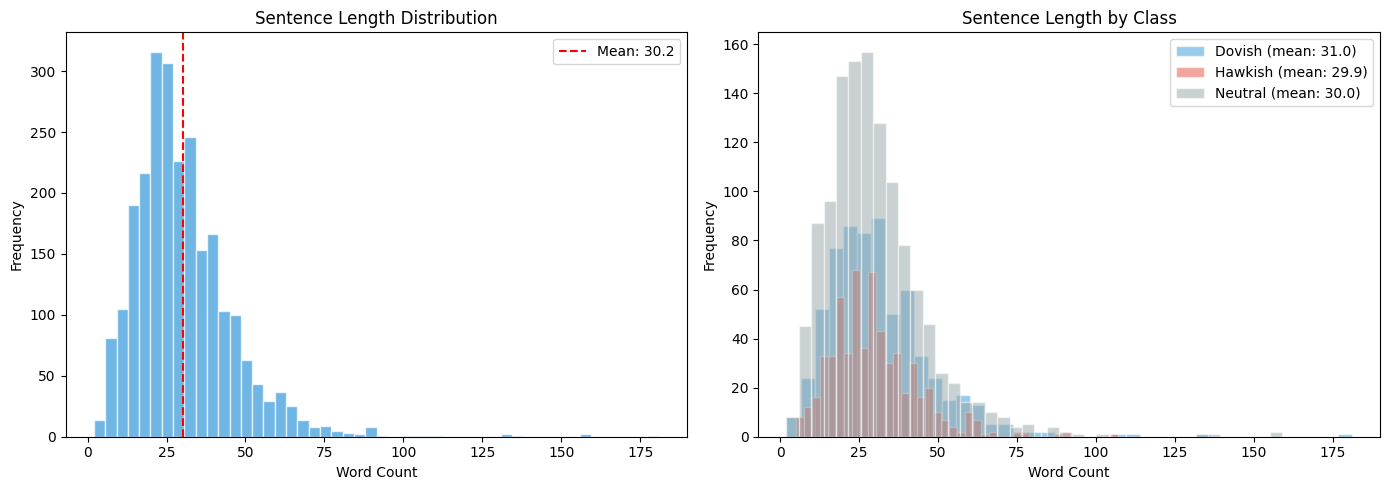


WORD COUNT BY CLASS
  Dovish     Mean: 31.0  Median: 28.0  Std: 16.8
  Hawkish    Mean: 29.9  Median: 28.0  Std: 13.9
  Neutral    Mean: 30.0  Median: 27.0  Std: 16.1


In [ ]:
# 3.2 Sentence length analysis
df_all['word_count'] = df_all['sentence'].str.split().str.len()
df_all['char_count'] = df_all['sentence'].str.len()

print("SENTENCE LENGTH STATISTICS")
print("=" * 50)
print(f"  Mean words:   {df_all['word_count'].mean():.1f}")
print(f"  Median words: {df_all['word_count'].median():.1f}")
print(f"  Min words:    {df_all['word_count'].min()}")
print(f"  Max words:    {df_all['word_count'].max()}")
print(f"  Std words:    {df_all['word_count'].std():.1f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall word count distribution
axes[0].hist(df_all['word_count'], bins=50, color='#3498db', alpha=0.7, edgecolor='white')
axes[0].axvline(df_all['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df_all['word_count'].mean():.1f}")
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sentence Length Distribution')
axes[0].legend()

# Word count by class
for label, color in colors.items():
    subset = df_all[df_all['label_name'] == label]['word_count']
    axes[1].hist(subset, bins=40, alpha=0.5, label=f"{label} (mean: {subset.mean():.1f})",
                 color=color, edgecolor='white')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Sentence Length by Class')
axes[1].legend()

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'sentence_lengths.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-class stats
print("\nWORD COUNT BY CLASS")
print("=" * 50)
for label in ['Dovish', 'Hawkish', 'Neutral']:
    subset = df_all[df_all['label_name'] == label]['word_count']
    print(f"  {label:<10} Mean: {subset.mean():.1f}  Median: {subset.median():.1f}  Std: {subset.std():.1f}")

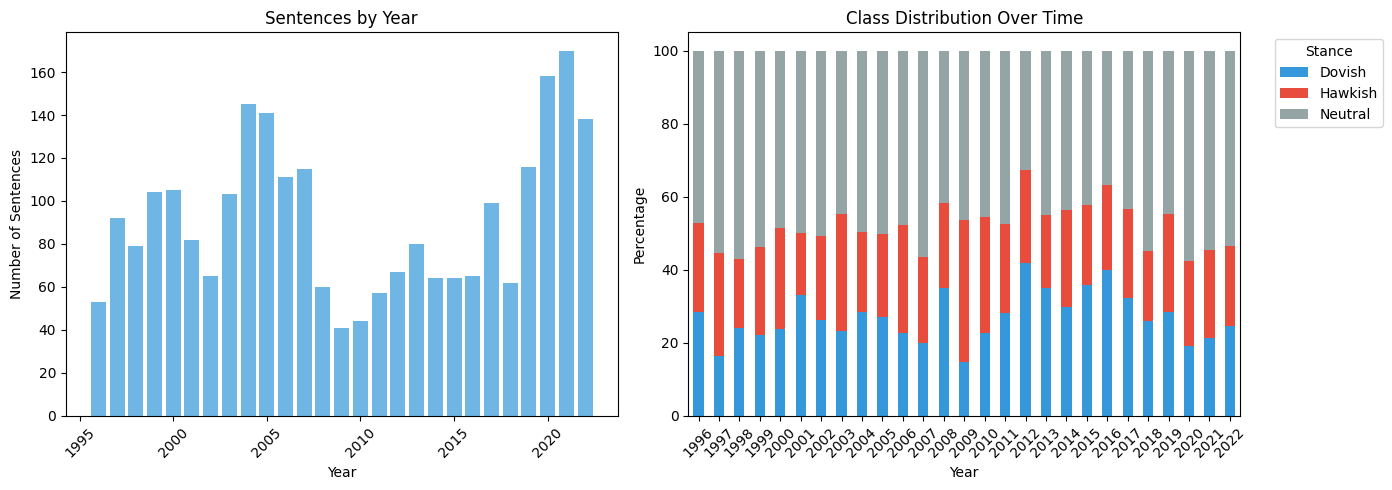

In [ ]:
# 3.3 Temporal distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentences per year
year_counts = df_all['year'].value_counts().sort_index()
axes[0].bar(year_counts.index, year_counts.values, color='#3498db', alpha=0.7)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Sentences')
axes[0].set_title('Sentences by Year')
axes[0].tick_params(axis='x', rotation=45)

# Class distribution over time (stacked)
year_class = df_all.groupby(['year', 'label_name']).size().unstack(fill_value=0)
year_class_pct = year_class.div(year_class.sum(axis=1), axis=0) * 100
year_class_pct[['Dovish', 'Hawkish', 'Neutral']].plot(
    kind='bar', stacked=True, ax=axes[1],
    color=[colors['Dovish'], colors['Hawkish'], colors['Neutral']])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Class Distribution Over Time')
axes[1].legend(title='Stance', bbox_to_anchor=(1.05, 1))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'temporal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# 3.4 Example sentences per class
print("EXAMPLE SENTENCES BY CLASS")
print("=" * 80)
for label in ['Dovish', 'Hawkish', 'Neutral']:
    print(f"\n--- {label.upper()} ---")
    samples = df_all[df_all['label_name'] == label].sample(3, random_state=42)
    for _, row in samples.iterrows():
        print(f"  [{row['year']}] {row['sentence'][:150]}...")
        if len(row['sentence']) > 150:
            print(f"          ...{row['sentence'][150:]}")
        print()

EXAMPLE SENTENCES BY CLASS

--- DOVISH ---
  [2004] The drop in demand leads, in turn, to a decline in actual output relative to its potential, that is, the level of output that the economy can produce ...
          ...at the maximum sustainable level of employment.

  [2007] However, growth of mortgage loans on banks' books slowed somewhat in the first half of this year....

  [2013] Some members expressed a concern that in this context any further adverse shocks could have disproportionate effects, resulting in a significant slowi...
          ...ng in growth going forward.


--- HAWKISH ---
  [2019] In addition, though the unemployment rate has fallen since the middle of 2003, the participation rate currently remains near the low point reached in ...
          ...the first half of 2004.

  [2003] We can best promote a progressive credit climate by maintaining an environment of low inflation....

  [2000] It is worth noting that today the economy is very strong and is well positioned

## 4. LLM Labeling with Claude

We use Claude (Sonnet) to independently label FOMC sentences as hawkish, dovish, or neutral,
then compare against the human annotations.

**Approach:**
- Send sentences in batches of 25 for efficiency
- Ask Claude to classify from an investor's perspective (matching the original annotation guidelines)
- Compare Claude's labels to human majority vote
- Analyze where Claude disagrees with human annotators

In [ ]:
# Set up Anthropic client
from anthropic import Anthropic
from google.colab import userdata

input_api_key = input("Enter your Claude API Key here: ")
client = Anthropic(api_key=input_api_key)

SYSTEM_PROMPT = """You are a monetary policy expert classifying sentences from Federal Reserve (FOMC) communications.

For each sentence, classify it as:
- HAWKISH: Indicates future monetary policy tightening (raising interest rates, reducing money supply, concerns about inflation being too high)
- DOVISH: Indicates future monetary policy easing (lowering interest rates, increasing money supply, concerns about weak employment/growth)
- NEUTRAL: Factual, balanced, or not clearly signaling either direction

Consider the sentence from an investor's perspective: would this signal tighter policy (hawkish), looser policy (dovish), or neither (neutral)?

IMPORTANT: Respond ONLY with the classification for each sentence in the exact format:
idx: LABEL
where idx is the sentence number and LABEL is one of HAWKISH, DOVISH, or NEUTRAL.
No explanations, no extra text."""

def label_batch(sentences, start_idx=0):
    """Label a batch of sentences using Claude."""
    # Format sentences with indices
    formatted = "\n".join([f"{start_idx + i}: {s}" for i, s in enumerate(sentences)])
    prompt = f"Classify each sentence:\n\n{formatted}"

    response = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=1000,
        system=SYSTEM_PROMPT,
        messages=[{"role": "user", "content": prompt}]
    )

    # Parse response
    results = {}
    for line in response.content[0].text.strip().split("\n"):
        line = line.strip()
        if ":" in line:
            parts = line.split(":", 1)
            try:
                idx = int(parts[0].strip())
                label = parts[1].strip().upper()
                if label in ['HAWKISH', 'DOVISH', 'NEUTRAL']:
                    results[idx] = label
            except (ValueError, IndexError):
                continue
    return results

# Test with a small batch
test_sentences = [
    "And that, I think, does raise the risk that high inflation will be more persistent.",
    "The committee will continue to monitor incoming data.",
    "Recent declines in payroll employment, while still sizable, were smaller than earlier."
]
test_results = label_batch(test_sentences)
print("Test results:")
for idx, label in test_results.items():
    print(f"  {idx}: {label} -> '{test_sentences[idx][:80]}...'")
print("\nLLM labeling pipeline works!")

Test results:
  0: HAWKISH -> 'And that, I think, does raise the risk that high inflation will be more persiste...'
  1: NEUTRAL -> 'The committee will continue to monitor incoming data....'
  2: DOVISH -> 'Recent declines in payroll employment, while still sizable, were smaller than ea...'

LLM labeling pipeline works!


In [ ]:
# Label ALL sentences in batches
BATCH_SIZE = 25
all_sentences = df_all['sentence'].tolist()
llm_labels = {}

print(f"Labeling {len(all_sentences)} sentences in batches of {BATCH_SIZE}...")
print(f"Estimated batches: {len(all_sentences) // BATCH_SIZE + 1}")
print()

for batch_start in range(0, len(all_sentences), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(all_sentences))
    batch = all_sentences[batch_start:batch_end]

    batch_num = batch_start // BATCH_SIZE + 1
    total_batches = len(all_sentences) // BATCH_SIZE + 1

    try:
        results = label_batch(batch, start_idx=batch_start)
        llm_labels.update(results)

        if batch_num % 10 == 0 or batch_num == 1:
            print(f"  Batch {batch_num}/{total_batches} done — {len(llm_labels)} labels so far")

        time.sleep(1)  # Rate limiting

    except Exception as e:
        print(f"  Error in batch {batch_num}: {e}")
        time.sleep(5)
        # Retry once
        try:
            results = label_batch(batch, start_idx=batch_start)
            llm_labels.update(results)
        except Exception as e2:
            print(f"  Retry failed: {e2}")
            continue

print(f"\nDone! Labeled {len(llm_labels)} / {len(all_sentences)} sentences ({len(llm_labels)/len(all_sentences)*100:.1f}%)")

# Save raw LLM labels
with open(DRIVE_PATH + 'llm_labels_fomc.json', 'w') as f:
    json.dump(llm_labels, f, indent=2)
print(f"Saved to: {DRIVE_PATH}llm_labels_fomc.json")

Labeling 2480 sentences in batches of 25...
Estimated batches: 100

  Batch 1/100 done — 25 labels so far
  Batch 10/100 done — 250 labels so far
  Batch 20/100 done — 500 labels so far
  Batch 30/100 done — 750 labels so far
  Batch 40/100 done — 1000 labels so far
  Batch 50/100 done — 1250 labels so far
  Batch 60/100 done — 1500 labels so far
  Batch 70/100 done — 1750 labels so far
  Batch 80/100 done — 2000 labels so far
  Batch 90/100 done — 2250 labels so far
  Batch 100/100 done — 2480 labels so far

Done! Labeled 2480 / 2480 sentences (100.0%)
Saved to: /content/drive/MyDrive/Colab Notebooks/llm_labels_fomc.json


## 5. LLM vs Human Label Comparison

How well does Claude agree with the human annotators? Where does it disagree, and why?

In [ ]:
# Map LLM labels to numeric
LLM_LABEL_MAP = {'DOVISH': 0, 'HAWKISH': 1, 'NEUTRAL': 2}

# Add LLM labels to dataframe
df_all['llm_label_str'] = df_all.index.map(lambda i: llm_labels.get(i, None))
df_all['llm_label'] = df_all['llm_label_str'].map(LLM_LABEL_MAP)

# Filter to sentences where we have both labels
df_compare = df_all.dropna(subset=['llm_label']).copy()
df_compare['llm_label'] = df_compare['llm_label'].astype(int)

print(f"Sentences with both human and LLM labels: {len(df_compare)}")
print(f"Missing LLM labels: {len(df_all) - len(df_compare)}")

# Overall agreement
agreement = (df_compare['label'] == df_compare['llm_label']).mean()
print(f"\nOverall agreement: {agreement:.1%}")

Sentences with both human and LLM labels: 2480
Missing LLM labels: 0

Overall agreement: 68.6%


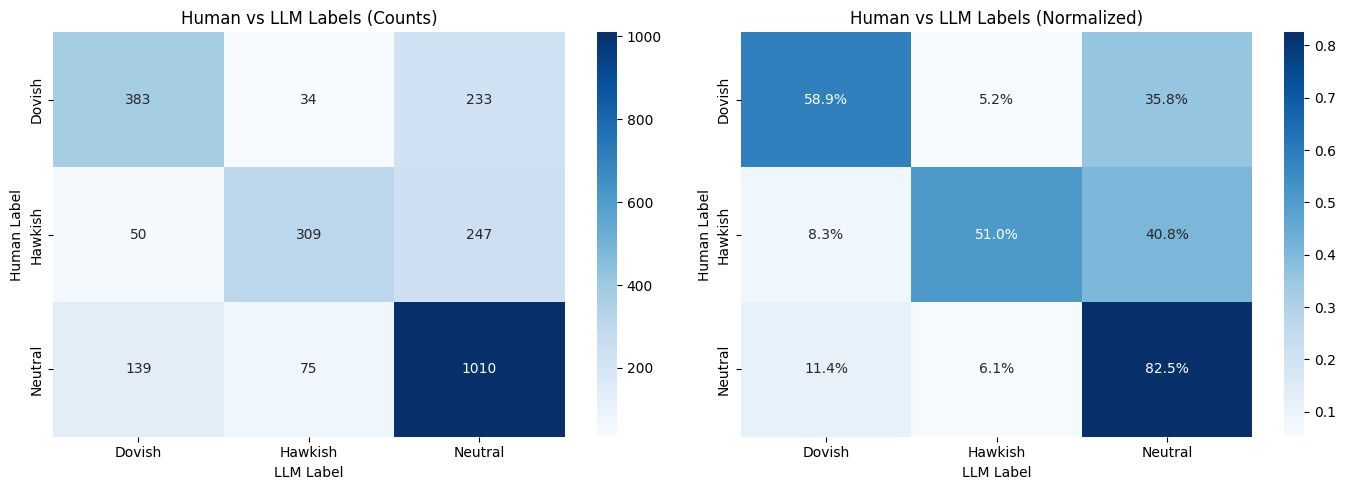

LLM PERFORMANCE vs HUMAN ANNOTATIONS
              precision    recall  f1-score   support

      Dovish      0.670     0.589     0.627       650
     Hawkish      0.739     0.510     0.604       606
     Neutral      0.678     0.825     0.744      1224

    accuracy                          0.686      2480
   macro avg      0.696     0.641     0.658      2480
weighted avg      0.691     0.686     0.679      2480

Cohen's Kappa: 0.479


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Confusion matrix: Human (rows) vs LLM (columns)
labels = [0, 1, 2]
label_names = ['Dovish', 'Hawkish', 'Neutral']

cm = confusion_matrix(df_compare['label'], df_compare['llm_label'], labels=labels)
cm_norm = confusion_matrix(df_compare['label'], df_compare['llm_label'], labels=labels, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_names, yticklabels=label_names)
axes[0].set_xlabel('LLM Label')
axes[0].set_ylabel('Human Label')
axes[0].set_title('Human vs LLM Labels (Counts)')

sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Blues', ax=axes[1],
            xticklabels=label_names, yticklabels=label_names)
axes[1].set_xlabel('LLM Label')
axes[1].set_ylabel('Human Label')
axes[1].set_title('Human vs LLM Labels (Normalized)')

plt.tight_layout()
plt.savefig(DRIVE_PATH + 'llm_vs_human_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report (treating human labels as ground truth)
print("LLM PERFORMANCE vs HUMAN ANNOTATIONS")
print("=" * 60)
print(classification_report(df_compare['label'], df_compare['llm_label'],
                           target_names=label_names, digits=3))

kappa = cohen_kappa_score(df_compare['label'], df_compare['llm_label'])
print(f"Cohen's Kappa: {kappa:.3f}")

In [ ]:
# Per-class agreement
print("PER-CLASS AGREEMENT RATES")
print("=" * 50)
for label_id, label_name in LABEL_MAP.items():
    mask = df_compare['label'] == label_id
    if mask.sum() > 0:
        class_agreement = (df_compare.loc[mask, 'label'] == df_compare.loc[mask, 'llm_label']).mean()
        print(f"  {label_name:<10} {class_agreement:.1%}  (n={mask.sum()})")

# Interesting disagreements
print("\nINTERESTING DISAGREEMENTS (Human vs LLM)")
print("=" * 80)
disagreements = df_compare[df_compare['label'] != df_compare['llm_label']].copy()
disagreements['human_name'] = disagreements['label'].map(LABEL_MAP)
disagreements['llm_name'] = disagreements['llm_label'].map(LABEL_MAP)

# Sample disagreements by type
for (h, l), group in disagreements.groupby(['human_name', 'llm_name']):
    if len(group) >= 2:
        print(f"\n  Human={h}, LLM={l} ({len(group)} cases):")
        for _, row in group.head(2).iterrows():
            sent = row['sentence'][:120]
            print(f"    [{row['year']}] {sent}...")

PER-CLASS AGREEMENT RATES
  Dovish     58.9%  (n=650)
  Hawkish    51.0%  (n=606)
  Neutral    82.5%  (n=1224)

INTERESTING DISAGREEMENTS (Human vs LLM)

  Human=Dovish, LLM=Hawkish (34 cases):
    [2011] But I want to emphasize that we do have a commitment to raising inflation to 2 percent....
    [2017] Some of the increase in sentiment and changes in asset prices could be tied to expectations of more expansive fiscal pol...

  Human=Dovish, LLM=Neutral (233 cases):
    [2007] That said, the data also indicate that a surge in COVID-19 cases in the summer and supply-chain bottlenecks held back ec...
    [1996] Fiscal policy, on the other hand, can be an instrument of growth policy, through its effect on national saving via the s...

  Human=Hawkish, LLM=Dovish (50 cases):
    [2002] Our new statement explicitly acknowledges the challenges posed by the proximity of interest rates to the effective lower...
    [2002] Many observed, however, that a favorable outcome to the hostilities in

## 6. Prepare Train / Validation / Test Splits

The original dataset provides a train/test split. We further split the training data
to create a validation set: **70% train / 15% validation / 15% test** (stratified by label).

In [ ]:
# We'll use the original test set and split the original train into train + val
# This preserves the original authors' test set for fair comparison

df_train_orig = df_all.iloc[:len(df_train_raw)].copy()
df_test = df_all.iloc[len(df_train_raw):].copy()

# Split original train into new train + validation (85/15 of original train ≈ 70/15 overall)
df_train, df_val = train_test_split(
    df_train_orig,
    test_size=0.15,
    stratify=df_train_orig['label'],
    random_state=42
)

print("DATASET SPLITS")
print("=" * 50)
print(f"  Train:      {len(df_train):>6}  ({len(df_train)/len(df_all)*100:.1f}%)")
print(f"  Validation: {len(df_val):>6}  ({len(df_val)/len(df_all)*100:.1f}%)")
print(f"  Test:       {len(df_test):>6}  ({len(df_test)/len(df_all)*100:.1f}%)")
print(f"  Total:      {len(df_all):>6}")

# Verify stratification
print("\nLABEL DISTRIBUTION PER SPLIT")
print("=" * 50)
for split_name, split_df in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    dist = split_df['label_name'].value_counts(normalize=True) * 100
    print(f"  {split_name:<12} Dovish: {dist.get('Dovish', 0):.1f}%  Hawkish: {dist.get('Hawkish', 0):.1f}%  Neutral: {dist.get('Neutral', 0):.1f}%")

DATASET SPLITS
  Train:        1686  (68.0%)
  Validation:    298  (12.0%)
  Test:          496  (20.0%)
  Total:        2480

LABEL DISTRIBUTION PER SPLIT
  Train        Dovish: 26.0%  Hawkish: 24.8%  Neutral: 49.2%
  Val          Dovish: 25.8%  Hawkish: 24.8%  Neutral: 49.3%
  Test         Dovish: 27.2%  Hawkish: 23.0%  Neutral: 49.8%


In [ ]:
# Save splits
df_train.to_csv(DRIVE_PATH + 'train.csv', index=False)
df_val.to_csv(DRIVE_PATH + 'val.csv', index=False)
df_test.to_csv(DRIVE_PATH + 'test.csv', index=False)

print(f"Saved train.csv ({len(df_train)} rows)")
print(f"Saved val.csv ({len(df_val)} rows)")
print(f"Saved test.csv ({len(df_test)} rows)")

# Also save the full dataset with LLM labels for later analysis
df_all.to_csv(DRIVE_PATH + 'fomc_all_with_llm.csv', index=False)
print(f"Saved fomc_all_with_llm.csv ({len(df_all)} rows)")

Saved train.csv (1686 rows)
Saved val.csv (298 rows)
Saved test.csv (496 rows)
Saved fomc_all_with_llm.csv (2480 rows)


## 7. Summary

### Dataset Overview
- **Source:** "Trillion Dollar Words" (Shah et al., ACL 2023)
- **Size:** ~2,480 annotated FOMC sentences (1996–2022)
- **Classes:** Dovish / Hawkish / Neutral (3-class)
- **Source types:** Meeting minutes, press conferences, speeches

### Key EDA Findings
- Class distribution is imbalanced (neutral-heavy, typical for FOMC text)
- Sentence lengths vary considerably — some are very long multi-clause constructions
- Temporal coverage spans multiple monetary policy regimes (dot-com, GFC, COVID, inflation era)

### LLM Labeling
- Claude independently labeled all sentences
- Agreement rate and Cohen's Kappa reported above
- Disagreements reveal genuinely ambiguous monetary policy language

### Files Saved
- `train.csv`, `val.csv`, `test.csv` — stratified splits
- `fomc_all_with_llm.csv` — full dataset with LLM labels
- `llm_labels_fomc.json` — raw LLM label outputs
- EDA charts: `class_distribution.png`, `sentence_lengths.png`, `temporal_distribution.png`
- Comparison chart: `llm_vs_human_confusion.png`

### Next Step
- **Step 2:** Train FinBERT and RoBERTa models, evaluate and compare